In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import torch

In [2]:
from src.models import TranAD, iTransformer


In [3]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [4]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [25]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

In [26]:
# configs for lxplus results
config = {
 'iTransformer1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w10 s1 l2'},
 'iTransformer2': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w100 s50 l2'},
 'iTransformer3': {'window': 10, 'steps': 5, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w10 s5 l2'},
 'iTransformer4': {'window': 100, 'steps': 10, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w100 s10 l2'},
 'iTransformer5': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer fc: w10 s1 l2', 'forecasting': True},
 'iTransformer6': {'window': 100, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer fc: w100 s1 l2', 'forecasting': True},
 'TranAD': {'window': 10, 'steps': 1, 'eps': 100, 'latent': '', 'lab': 'TranAD: w10 s1'},
#  'MAD_GAN': {'lab': 'MAD_GAN'},
#  'OmniAnomaly': {'lab': 'OmniAnomaly'},
#  'LSTM_AE': {'lab': 'LSTM_AE'},
#  'DAGMM': {'lab': 'DAGMM'},
#  'USAD': {'lab': 'USAD'},
#  'IF': {'lab': 'IF'},
#  'None': {'lab': 'None'}
}

## validation losses

In [7]:
datasets = ['creditcard_normal']  # 'GECCO_normal','GECCO', 'IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'SMAP_new', 'MSL_new', 'SMD'] 
models = ['iTransformer1', 'iTransformer2', 'iTransformer3', 'iTransformer4', 'TranAD']


all_paths = []
losses = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}')
            # paths = glob.glob(f'iTransformer/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}_results_lxplus/{model}_{dataset}')
            # paths = glob.glob(f'{model}/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/checkpoints/model_final.ckpt")
                else:
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/checkpoints/model_final.ckpt")
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/checkpoints/model_final.ckpt')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                key = res_path[0].split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                        idx = len('iTransformer')  # len(model) - 1
                        diff = len(model) - len('iTransformer')
                        # insert a number in the key to distinguish between the models at position idx
                        key = key[:idx] + model[-diff:] + key[idx:]
                losses[key] = {'val_loss': [], 'train_loss': []}
                for i, p in enumerate(res_path):
                    model = torch.load(p)
                    accuracy_list = model['accuracy_list']
                    lossT = [i[0] for i in accuracy_list]
                    lossV = [i[1] for i in accuracy_list] 
                    losses[key]['val_loss'].append(lossV)
                    losses[key]['train_loss'].append(lossT)
            else:
                print(f'No results found for {model} on {dataset}')

print(losses.keys())
# print(len(losses['iTransformer_GECCO']['val_loss']), len(losses['iTransformer_GECCO']['val_loss'][0]))

iTransformer1 creditcard_normal 5


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/1445228963.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)


iTransformer2 creditcard_normal 5


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/1445228963.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)


iTransformer3 creditcard_normal 5


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/1445228963.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)


iTransformer4 creditcard_normal 5


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/1445228963.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)


TranAD creditcard_normal 5


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/1445228963.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)


dict_keys(['iTransformer1_creditcard_normal', 'iTransformer2_creditcard_normal', 'iTransformer3_creditcard_normal', 'iTransformer4_creditcard_normal', 'TranAD_creditcard_normal'])


In [15]:
# Plot training and validation losses
def plot_losses(losses, dataset):
    # colors = current_cycler.by_key()['color']
    colors = plt.cm.viridis(np.linspace(0, 1, 5))

    for key in losses.keys():
        if dataset in key:
            print(key)
            train_losses = losses[key]['train_loss']
            val_losses = losses[key]['val_loss']
            for i in range(len(train_losses)):
                plt.plot(train_losses[i], '-o', label=f'Train loss fold {i+1}', color=colors[i])
                plt.plot(val_losses[i], '-*', label=f'Val loss fold {i+1}', color=colors[i], markersize=8)
            plt.ylim(0, 1.3)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Losses on {dataset}')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'./studies_results_lxplus/losses/{key}_losses.png', facecolor='w')
            plt.show()
            plt.close()


In [13]:
%matplotlib inline

iTransformer1_creditcard_normal


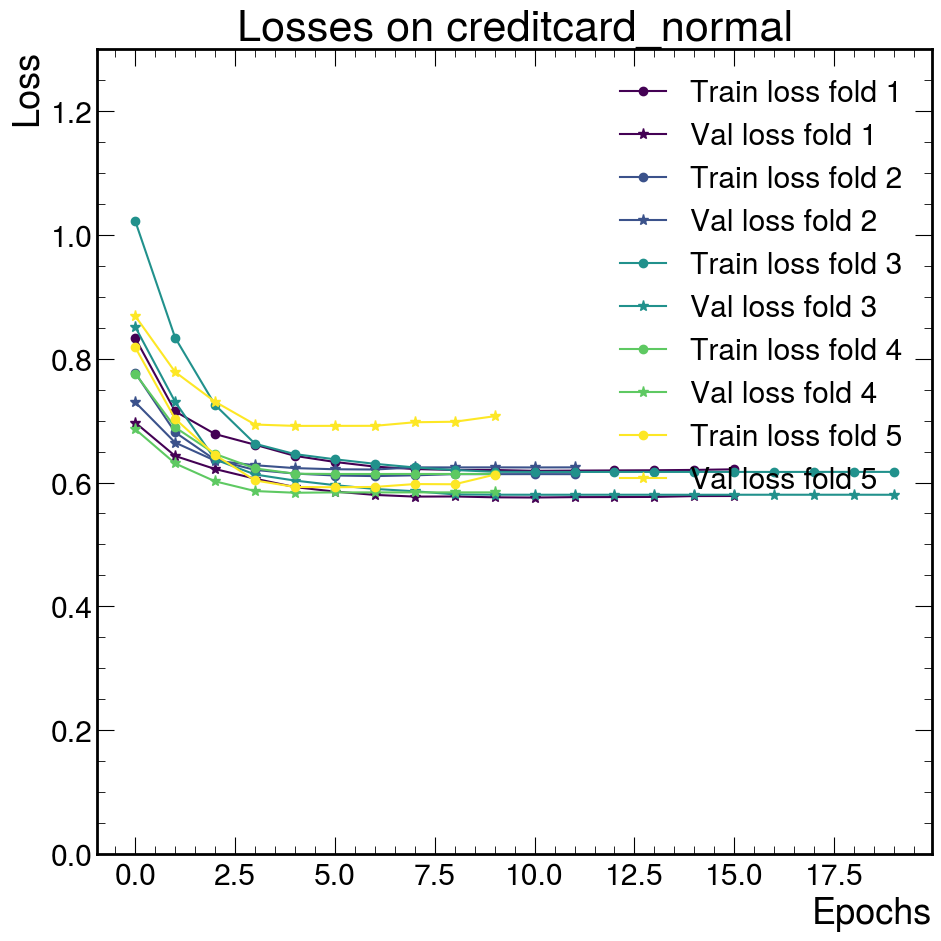

iTransformer2_creditcard_normal


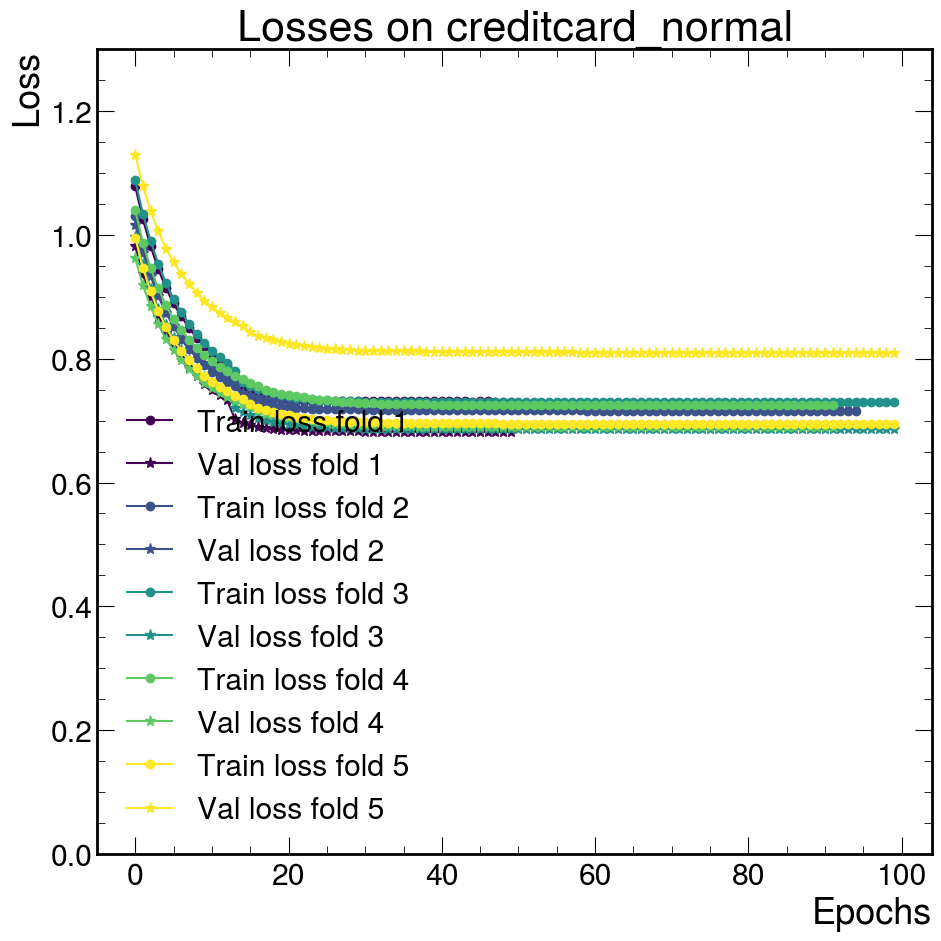

iTransformer3_creditcard_normal


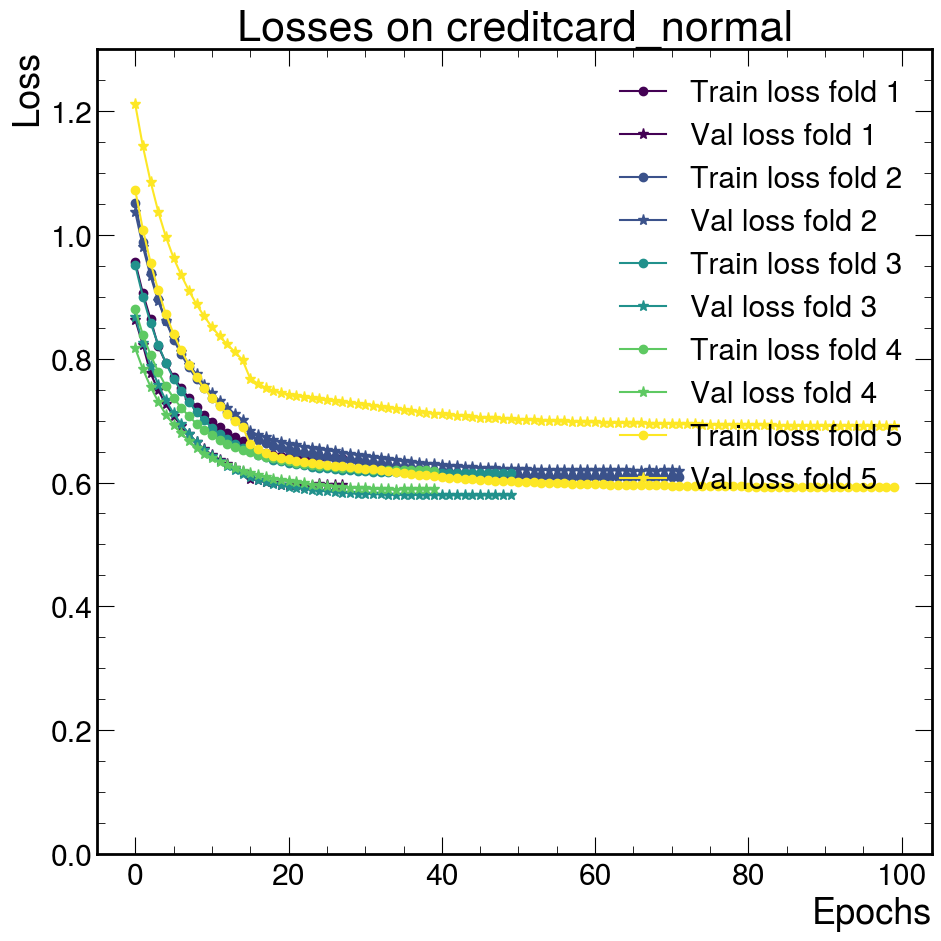

iTransformer4_creditcard_normal


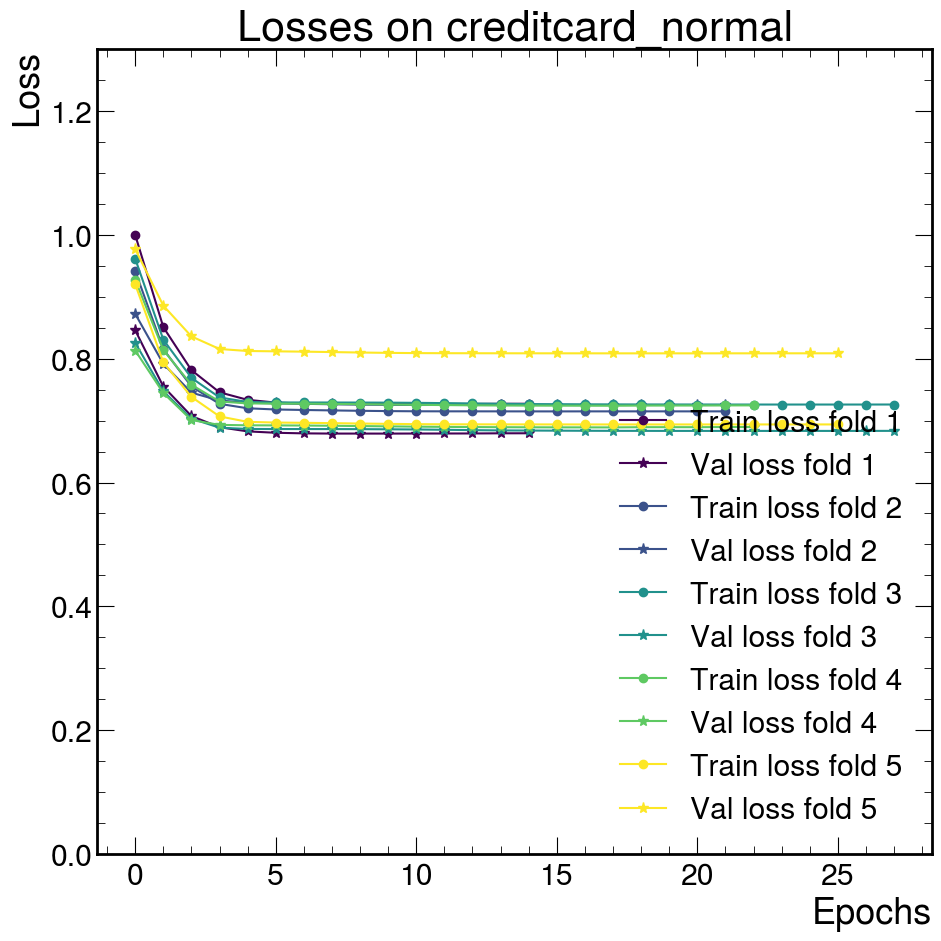

TranAD_creditcard_normal


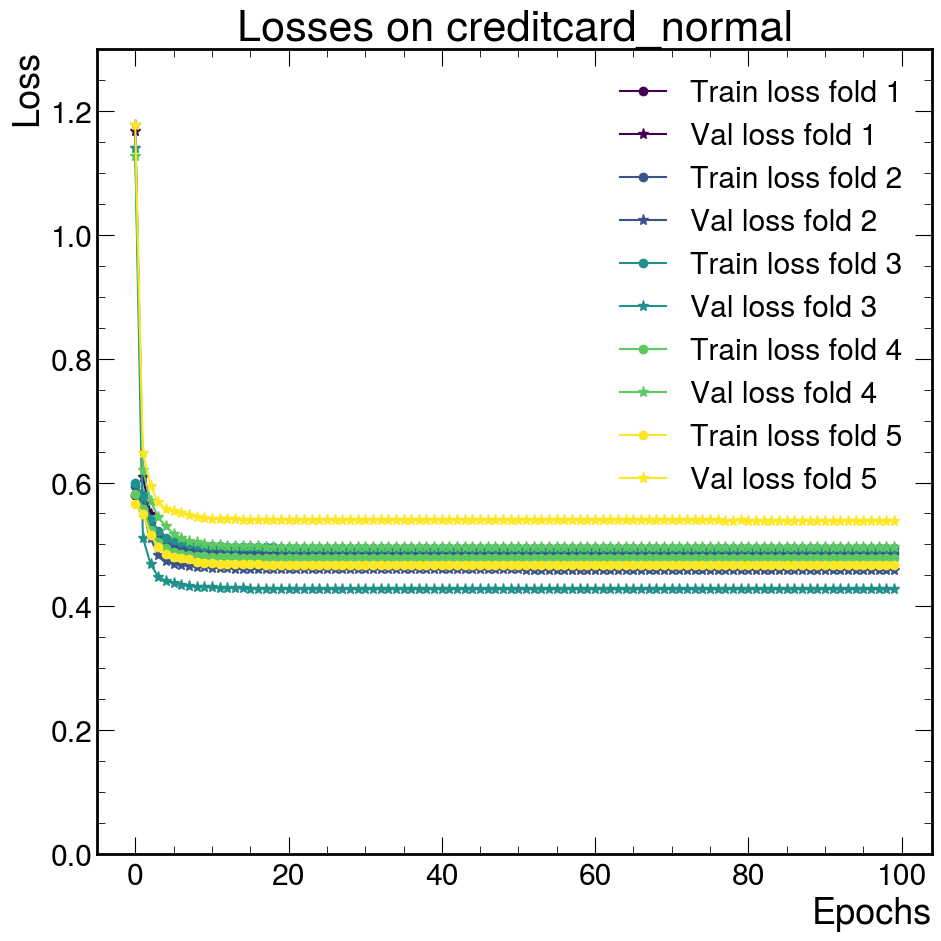

In [16]:
# Usage
for dataset in ['creditcard_normal']: # datasets:
    plot_losses(losses, dataset)

## performance plots

In [ ]:
datasets = ['IEEECIS_new2.2', 'SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT_1D', 'GECCO', 'SMD']  #, 'ATLAS_TS']
models = ['iTransformer1', 'iTransformer2', 'iTransformer3', 'TranAD']
        #   'OmniAnomaly', 'MAD_GAN', 'LSTM_AE', 'DAGMM', 'USAD', 'IF', 'None'] 

all_paths = []
results_mean_std = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}_results_lxplus/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/results/res.csv")
                else:
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/results/res.csv")
            elif model == 'None':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            elif model == 'IF':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/results/res.csv')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                for p in res_path:
                    res = pd.read_csv(p)
                    tmp = pd.concat((tmp, res.iloc[-3:]))

                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len('iTransformer')  # len(model) - 1
                    diff = len(model) - len('iTransformer')
                    # insert a number in the key to distinguish between the models at position idx
                    key = key[:idx] + model[-diff:] + key[idx:]

                mean_values = tmp.groupby('Unnamed: 0').mean()
                std_values = tmp.groupby('Unnamed: 0').std()
                mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
                std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
                results_mean_std[key] = {'mean': mean_values, 'std': std_values}
                # print(results_mean_std[key])
            else:
                print(f'No results found for {model} on {dataset}')

            break

# print(len(all_paths))
print(results_mean_std.keys())

In [ ]:
plt.rcParams.update({'lines.markersize': 6})
plt.rcParams.update({'errorbar.capsize': 8})
plt.rcParams.update({'lines.linewidth': 2})

In [ ]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

In [ ]:
def plot_scores_mean_std_err(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    # colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharex=True, sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
               
                for val in ['mean', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                    else:
                        scores[val] = np.append(scores[val], 0)
            
            x_positions = np.arange(len(datasets)) + j * 0.1  # add offset for each model
            if labels:
                axs[i].errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=labels[j])  #, color=colors[j % len(colors)], capsize=5)
            else:
                axs[i].errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=model)  #, color=colors[j % len(colors)], capsize=5)
            
            axs[i].set_xticks(np.arange(len(datasets)) + 0.1 * (len(models) - 1) / 2)
            axs[i].set_xticklabels(labels=datasets)
            if metric == 'MCC':
                axs[i].set_ylim(-1, 1)
            else:
                axs[i].set_ylim(top=1.0)
            if metric == 'ROC/AUC':
                axs[i].set_ylabel('ROC AUC')
            elif metric == 'f1':
                axs[i].set_ylabel('F1')
            else:
                axs[i].set_ylabel(metric)
            axs[i].set_title(mode)
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_results_lxplus/{name}_{metric}.png', facecolor='w')
    plt.show()


In [ ]:
def plot_best_scores_mean_std_err(results, datasets, models, metric='MCC', name=None, labels=None):
    fig, ax = plt.subplots(figsize=(20, 6))

    for j, model in enumerate(models):
        scores = {'mean': np.empty(0), 'std': np.empty(0)}
        for dataset in datasets:
            key = f'{model}_{dataset}'
            
            if key in results:
                scores['mean'] = np.append(scores['mean'], results[key]['mean'][metric].max())
                idx = np.where(results[key]['mean'][metric] == results[key]['mean'][metric].max())[0][0]
                scores['std'] = np.append(scores['std'], results[key]['std'][metric].iloc[idx])
            else:
                scores['mean'] = np.append(scores['mean'], 0)
                scores['std'] = np.append(scores['std'], 0)
        
        x_positions = np.arange(len(datasets)) + j * 0.1  # add offset for each model
        if labels:
            ax.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=labels[j])  
        else:
            ax.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=model) 
            
    ax.set_xticks(np.arange(len(datasets)) + 0.1 * (len(models) - 1) / 2)
    ax.set_xticklabels(datasets)
    # ax.set_ylim(top=1.0)
    if metric == 'ROC/AUC':
        ax.set_ylabel('ROC AUC')
        ax.set_title(f'Best ROC AUC Scores')
        metric = 'rocauc'
    elif metric == 'f1':
        ax.set_ylabel('F1')
        ax.set_title(f'Best F1 Scores')
    else:
        ax.set_ylabel(metric)    
        ax.set_title(f'Best {metric} scores')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_results_lxplus/{name}_{metric}best.png', facecolor='w')
    plt.show()

In [ ]:
data_plot = ['IEEECIS_new2.2', 'GECCO', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT_1D', 'UCR'] 
models_plot = ['iTransformer4'] #, 'MAD_GAN', 'OmniAnomaly', 'LSTM_AE', 'DAGMM', 'USAD']
lab = [config[m]['lab'] for m in models_plot]

name = None  # 'new'  # 'rep5_new_all'
plot_best_scores_mean_std_err(results_mean_std, data_plot, models_plot, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_err(results_mean_std, modes, data_plot, models_plot, metric='MCC', labels=lab, name=name)

In [ ]:
def list_results(results, datasets, models, metric='MCC', labels=None, val='mean'):
    dict = {}
    for j, model in enumerate(models):
        mcc_scores = []
        for dataset in datasets:
            key = f'{model}_{dataset}'
            print(key)
            if key in results:
                mcc_scores.append(results[key][val][metric].max().round(3))
            else:
                mcc_scores.append(0)  # If no data, append 0

            dict[labels[j]] = mcc_scores

    return dict

In [ ]:
def list_results(results, datasets, models, metric='MCC', labels=None):
    dict = {}
    for j, model in enumerate(models):
        scores = []
        for dataset in datasets:
            key = f'{model}_{dataset}'
            print(key)
            if key in results:
                scores.append(rf"${results[key]['mean'][metric].round(3)} \pm {results[key]['mean'][metric].round(3)}$")
            else:
                scores.append(0)  # If no data, append 0

            dict[labels[j]] = scores

    return dict

In [ ]:
val = 'mean'
metric = 'train_loss'
namee = 'latent2_rep5_new'
data3 = ['IEEECIS_new2.2', 'GECCO', 'SMD', 'SMAP_new', 'MSL_new','UCR']
# ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO6', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT', 'UCR'] #'ATLAS_TS',
models3 = ['iTransformer3', 'iTransformer4', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'iTransformer11', 'TranAD']
# ['iTransformer3', 'iTransformer5', 'iTransformer7', 'iTransformer10', 'TranAD']
# ['iTransformer3', 'iTransformer5', 'iTransformer7', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'TranAD']
lab = [config[m]['lab'] for m in models3]

dict_bestMCC = list_results(results_mean_std, data3, models3, metric, labels=lab, val=val)
df_bestMCC = pd.DataFrame(dict_bestMCC, index=data3).T
print(df_bestMCC)
print(df_bestMCC.values)
metric = metric.replace(' ', '_')
# df_bestMCC.to_csv(f'studies_earlystopping/data/best{metric}_{namee}_{val}.csv')

## plot valid vs train sets

In [ ]:
from src.data_loader import MyDataset
from src.plotting import features_dict

In [ ]:
%matplotlib inline

In [ ]:
def plot_train_valid(dataset):
    for k in range(1, 5):
        # window and step size don't matter because we use complete data
        train = MyDataset(dataset, 100, 100, 'iTransformer', flag='train', feats=-1, enc=False, k=k)
        valid = MyDataset(dataset,  100, 100, 'iTransformer', flag='valid', feats=-1, enc=False, k=k)
        x_train = train.get_complete_data()
        x_valid = valid.get_complete_data()
        feats = x_train.shape[1]
        # print(train.__len__(), valid.__len__())
        # print(x_train.shape, x_valid.shape)
        if feats > 30:
            feats = 30
            x_train = x_train[:, :feats]
            x_valid = x_valid[:, :feats]

        if dataset in features_dict.keys():
            features = features_dict[dataset]
        else:
            features = [f'Dim {i}' for i in range(feats)]
        size = int(len(features))

        if feats > 1:
            fig, axs = plt.subplots(feats, 1, figsize=(15, size), sharex=True, constrained_layout=True)
            for i, feat in enumerate(features):
                axs[i].plot(x_train[:, i], label=f'Train')
                axs[i].plot(x_valid[:, i], '--', label=f'Valid fold {k}', color='tab:orange')
                # axs[2*i].plot(x_train[:, i], label=f'Train dim {i}')
                # axs[2*i+1].plot(x_valid[:, i], label=f'Valid dim {i}', color='tab:orange')
                axs[i].set_ylabel(feat, rotation=0, ha='right', rotation_mode='default', labelpad=5)
                axs[i].yaxis.set_label_coords(-0.1, 0.5)
            axs[0].set_title(f'Train and Validation data for {dataset}')
            if dataset == 'GECCO':
                axs[0].legend(ncol=2, bbox_to_anchor=(0.5, -0.1), loc='lower center', borderaxespad=0., frameon=False)
            else:
                axs[0].legend(ncol=2, bbox_to_anchor=(0.98, 0.25), loc='lower right', borderaxespad=0., frameon=False)
            axs[-1].set_xlabel('Timestamp')
        else:
            fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
            ax.plot(x_train, label='Train')
            ax.plot(x_valid, '--', label=f'Valid fold {k}', color='tab:orange')
            ax.set_ylabel(features[0], rotation=0, ha='right', rotation_mode='default', labelpad=5)
            ax.yaxis.set_label_coords(0.3, -0.3)
            ax.set_title(f'Train and Validation data for {dataset}')
            ax.legend(ncol=2, loc='upper right', borderaxespad=0., frameon=False)
            ax.set_xlabel('Timestamp')
        
        plt.savefig(f'./studies_results_lxplus/train_valid/{dataset}_valid_fold{k}.png', facecolor='w')
        # plt.show()
        plt.close()

In [ ]:
datasets = ['GECCO_normal']  #, 'MSL_new', 'SMD', 'GECCO', 'IEEECIS_new2.2'] #  'GECCO', 'IEEECIS_new2.2', 'UCR', 'SWaT_1D'

for dataset in datasets:
    plot_train_valid(dataset)

## study MSE vs MCC evolution

In [17]:
from main import backprop, local_pot, local_anomaly_labels
from src.data_loader import MyDataset, DataLoader
from src.pot import pot_eval
from src.diagnosis import hit_att, ndcg
import math

In [18]:
def load_model(modelname, dims, n_window, step_size=None, path=None, prob=False, weighted=False):
	import src.models
	model_class = getattr(src.models, modelname)
	if modelname == 'iTransformer':
		model = model_class(dims, n_window, step_size, prob, weighted).double()
	else:
		model = model_class(dims, n_window, prob).double()
	
	optimizer = torch.optim.AdamW(model.parameters() , lr=model.lr, weight_decay=1e-5)
	scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)

	print(f"Loading pre-trained model: {model.name} from {path}")
	checkpoint = torch.load(path)
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
	scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
	epoch = checkpoint['epoch']
	accuracy_list = checkpoint['accuracy_list']

	return model, optimizer, scheduler, epoch, accuracy_list

In [19]:
def get_scores(dataset, model, index, modeltype):
    if modeltype == 'iTransformer':
        checkpoints_path = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_{index}/checkpoints/model_epoch*.ckpt')
    else:
        checkpoints_path = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_{index}/checkpoints/model_epoch*.ckpt')
    checkpoints_path = sorted(checkpoints_path, key=lambda x: int(x.split('_')[-1].split('.')[0].replace('epoch', '')))
    print(len(checkpoints_path))
    res_path = os.path.join(checkpoints_path[0].split('/')[0], checkpoints_path[0].split('/')[1], 'results2', checkpoints_path[0].split('/')[2])
    print(res_path)
    if not os.path.exists(res_path):
        os.makedirs(res_path)

    flag_less = False
    feats = -1
    if dataset == 'IEEECIS_new2.2':
        feats = 30
    elif dataset in ['SMAP_new', 'SMD']:
        flag_less = True
    elif dataset == 'MSL_new' and modeltype == 'TranAD':
        flag_less = True

    test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='test', feats=feats, enc=False, less=flag_less, k=-1)
    train_test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='train', feats=feats, less=flag_less, enc=False, k=-1)
    feats = test.feats
    enc_feats = test.enc_feats
    labels = test.get_labels()

    for path in checkpoints_path:
        trained_model, optimizer, scheduler, epoch, accuracy_list = load_model(modeltype, feats, config[model]['window'], config[model]['steps'], path, prob=False, weighted=False)
        trained_model.eval()
        print(f'Loaded model from epoch {epoch}')

        if os.path.exists(f'{res_path}/res_epoch{epoch}.csv') and os.path.exists(f'{res_path}/pred_labels_epoch{epoch}.csv'):
            print(f'Epoch {epoch} already evaluated')
            continue

        data_loader_train_test = DataLoader(train_test, batch_size=trained_model.batch, shuffle=False)
        data_loader_test = DataLoader(test, batch_size=trained_model.batch, shuffle=False)
        
        lossT = backprop(-1, trained_model, data_loader_train_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=False)  # need anomaly scores on training data for POT
        loss, y_pred = backprop(-1, trained_model, data_loader_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=True)

        if 'iTransformer' in trained_model.name or trained_model.name in ['LSTM_AE']:
            # cut out the padding from test data, loss tensors
            lossT_tmp, loss_tmp, y_pred_tmp = [], [], []
            # print(test.get_ts_lengths(), np.sum(test.get_ts_lengths()), len(test.get_ts_lengths()))
            # print(test.get_ideal_lengths(), np.sum(test.get_ideal_lengths()), len(test.get_ideal_lengths()))
            start = 0
            for i, l in enumerate(test.get_ts_lengths()):
                loss_tmp.append(loss[start:start+l])
                y_pred_tmp.append(y_pred[start:start+l])
                start += test.get_ideal_lengths()[i]
            
            start = 0
            for i, l in enumerate(train_test.get_ts_lengths()):
                lossT_tmp.append(lossT[start:start+l])
                start += train_test.get_ideal_lengths()[i]

            lossT = np.concatenate(lossT_tmp, axis=0)
            loss = np.concatenate(loss_tmp, axis=0)
            y_pred = np.concatenate(y_pred_tmp, axis=0)
        train_loss = np.mean(lossT)
        test_loss = np.mean(loss)
        
        ### anomaly labels
        preds, _ = local_pot(loss, lossT, labels)
        true_labels = (np.sum(labels, axis=1) >= 1) + 0
        # local anomaly labels
        labelspred, result_local1 = local_anomaly_labels(preds, true_labels, nb_adim=1)
        majority = math.ceil(labels.shape[1] / 2)  # do majority voting over dimensions for local results instead of inclusive OR
        labelspred_maj, result_local2 = local_anomaly_labels(preds, true_labels, nb_adim=majority)

        # global anomaly labels
        lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
        true_labels = (np.sum(labels, axis=1) >= 1) + 0
        result_global, pred2 = pot_eval(lossTfinal, lossFinal, true_labels, None, f'all_dim')
        labelspred_glob = (pred2 >= 1) + 0
        result_global.update(hit_att(loss, labels))
        result_global.update(ndcg(loss, labels))
        result_global.update({'detection_level_q': 1e-5})
        result_global.update({'train_loss': train_loss, 'test_loss': test_loss})
        # print('\nglobal results') 
        # print(result_global)

        # saving results
        df_res_global = pd.DataFrame.from_dict(result_global, orient='index').T
        df_res_global.index = ['global']
        result_local1 = pd.DataFrame.from_dict(result_local1, orient='index').T
        result_local2 = pd.DataFrame.from_dict(result_local2, orient='index').T
        result_local1.index = ['local_all']
        result_local2.index = ['local_all_maj']
        df_res_local = pd.concat([result_local1, result_local2])
        df_res = pd.concat([df_res_local, df_res_global]) 
        df_labels = pd.DataFrame({'local': labelspred, 'local_maj': labelspred_maj, 'global': labelspred_glob})

        df_res.to_csv(f'{res_path}/res_epoch{epoch}.csv')    
        df_labels.to_csv(f'{res_path}/pred_labels_epoch{epoch}.csv', index=False)


In [31]:
modeltype = 'iTransformer'  #  'iTransformer'
datasets = ['creditcard_normal']  # ['GECCO_normal', 'GECCO'] #, 'IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'SMAP_new', 'MSL_new', 'SMD'] 
models = ['iTransformer1', 'iTransformer2', 'iTransformer3', 'iTransformer4']  # 'TranAD'

for dataset in datasets:
    for model in models:
        for i in range(1, 6):
            get_scores(dataset, model, i, modeltype)

16
iTransformer_results_lxplus/iTransformer_creditcard_normal/results2/n_window10_steps1_feats-1_eps100_latent2_1
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_1/checkpoints/model_epoch0.ckpt
Loaded model from epoch 0
Epoch 0 already evaluated
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_1/checkpoints/model_epoch1.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 1
Epoch 1 already evaluated
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_1/checkpoints/model_epoch2.ckpt
Loaded model from epoch 2
Epoch 2 already evaluated
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_1/checkpoints/model_epoch3.ckpt
Loaded model from epoch 3
Epoch 3 already evaluated
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_1/checkpoints/model_epoch4.ckpt
Loaded model from epoch 4
Epoch 4 already evaluated
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_1/checkpoints/model_epoch5.ckpt
Loaded model from epoch 5
Epoch 5 already evaluated
Loading pre-trained model: iTran

/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 2
local results with 1 anomalous dimensions for anomaly
{'FN': 7,
 'FP': 29633,
 'MCC': 0.04385427435583665,
 'ROC/AUC': 0.7939651243790811,
 'TN': 55702,
 'TP': 101,
 'detection level q': 1e-05,
 'f1': 0.006768911189079941,
 'precision': 0.0033967848243099535,
 'recall': 0.9351850985939724}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 9,
 'MCC': -0.0003651355898942576,
 'ROC/AUC': 0.49994726665494815,
 'TN': 85326,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch3.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 3
local results with 1 anomalous dimensions for anomaly
{'FN': 8,
 'FP': 29419,
 'MCC': 0.04342454422853987,
 'ROC/AUC': 0.7905893765095735,
 'TN': 55916,
 'TP': 100,
 'detection level q': 1e-05,
 'f1': 0.006750526471186678,
 'precision': 0.00338764863193616,
 'recall': 0.9259258401920518}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 11,
 'MCC': -0.00040367730814184105,
 'ROC/AUC': 0.4999355481338255,
 'TN': 85324,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch4.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 4
local results with 1 anomalous dimensions for anomaly
{'FN': 8,
 'FP': 29491,
 'MCC': 0.04333662307634698,
 'ROC/AUC': 0.7901675097491586,
 'TN': 55844,
 'TP': 100,
 'detection level q': 1e-05,
 'f1': 0.006734161006871834,
 'precision': 0.0033794058993006637,
 'recall': 0.9259258401920518}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 11,
 'MCC': -0.00040367730814184105,
 'ROC/AUC': 0.4999355481338255,
 'TN': 85324,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch5.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 5
local results with 1 anomalous dimensions for anomaly
{'FN': 8,
 'FP': 29504,
 'MCC': 0.043320775174172634,
 'ROC/AUC': 0.7900913393618615,
 'TN': 55831,
 'TP': 100,
 'detection level q': 1e-05,
 'f1': 0.006731214584669791,
 'precision': 0.00337792190130458,
 'recall': 0.9259258401920518}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 10,
 'MCC': -0.00038488895884303265,
 'ROC/AUC': 0.4999414073943868,
 'TN': 85325,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch6.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 6
local results with 1 anomalous dimensions for anomaly
{'FN': 8,
 'FP': 29490,
 'MCC': 0.04333784248395156,
 'ROC/AUC': 0.7901733690097199,
 'TN': 55845,
 'TP': 100,
 'detection level q': 1e-05,
 'f1': 0.006734387761578104,
 'precision': 0.003379520107002528,
 'recall': 0.9259258401920518}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 11,
 'MCC': -0.00040367730814184105,
 'ROC/AUC': 0.4999355481338255,
 'TN': 85324,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch7.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 7
local results with 1 anomalous dimensions for anomaly
{'FN': 7,
 'FP': 29454,
 'MCC': 0.044073062550611414,
 'ROC/AUC': 0.795013932019557,
 'TN': 55881,
 'TP': 101,
 'detection level q': 1e-05,
 'f1': 0.00680975787178903,
 'precision': 0.003417357467969089,
 'recall': 0.9351850985939724}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 11,
 'MCC': -0.00040367730814184105,
 'ROC/AUC': 0.4999355481338255,
 'TN': 85324,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch8.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 8
local results with 1 anomalous dimensions for anomaly
{'FN': 7,
 'FP': 29459,
 'MCC': 0.04406692993207129,
 'ROC/AUC': 0.7949846357167503,
 'TN': 55876,
 'TP': 101,
 'detection level q': 1e-05,
 'f1': 0.0068086102113245105,
 'precision': 0.003416779430508532,
 'recall': 0.9351850985939724}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 12,
 'MCC': -0.0004216296650233645,
 'ROC/AUC': 0.49992968887326417,
 'TN': 85323,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch9.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 9
local results with 1 anomalous dimensions for anomaly
{'FN': 7,
 'FP': 29452,
 'MCC': 0.04407551594126483,
 'ROC/AUC': 0.7950256505406796,
 'TN': 55883,
 'TP': 101,
 'detection level q': 1e-05,
 'f1': 0.006810217044314052,
 'precision': 0.003417588737719491,
 'recall': 0.9351850985939724}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 11,
 'MCC': -0.00040367730814184105,
 'ROC/AUC': 0.4999355481338255,
 'TN': 85324,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch10.ckpt
Loaded model from epoch 10


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


local results with 1 anomalous dimensions for anomaly
{'FN': 7,
 'FP': 29461,
 'MCC': 0.04406447722780151,
 'ROC/AUC': 0.7949729171956278,
 'TN': 55874,
 'TP': 101,
 'detection level q': 1e-05,
 'f1': 0.006808151255445053,
 'precision': 0.0034165482702738148,
 'recall': 0.9351850985939724}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 11,
 'MCC': -0.00040367730814184105,
 'ROC/AUC': 0.4999355481338255,
 'TN': 85324,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_2/checkpoints/model_epoch11.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 11
local results with 1 anomalous dimensions for anomaly
{'FN': 7,
 'FP': 29446,
 'MCC': 0.044082877290490284,
 'ROC/AUC': 0.7950608061040474,
 'TN': 55889,
 'TP': 101,
 'detection level q': 1e-05,
 'f1': 0.006811594933500684,
 'precision': 0.0034182827348230673,
 'recall': 0.9351850985939724}
local results with 15 anomalous dimensions for anomaly
{'FN': 108,
 'FP': 12,
 'MCC': -0.0004216296650233645,
 'ROC/AUC': 0.49992968887326417,
 'TN': 85323,
 'TP': 0,
 'detection level q': 1e-05,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}
20
iTransformer_results_lxplus/iTransformer_creditcard_normal/results2/n_window10_steps1_feats-1_eps100_latent2_3
Loading pre-trained model: iTransformer from iTransformer_results_lxplus/iTransformer_creditcard_normal/n_window10_steps1_feats-1_eps100_latent2_3/checkpoints/model_epoch0.ckpt


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_94846/4260947400.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loaded model from epoch 0


KeyboardInterrupt: 

In [ ]:
modeltype = 'TranAD' 
datasets = ['creditcard_normal']  # ['GECCO', 'GECCO_normal'] # 'IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'SMAP_new', 'MSL_new', 'SMD'] 
models = ['TranAD']

for dataset in datasets:
    for model in models:
        for i in range(1, 6):
            get_scores(dataset, model, i, modeltype)

In [28]:
def get_data(datasets, models, modeltype):
    data = {f'{dataset}_{model}_fold{i}': {} for dataset in datasets for model in models for i in range(1, 6)}

    for dataset in datasets:
        for model in models:
            print(dataset, model)
            for i in range(1, 6):
                if modeltype == 'iTransformer':
                    datapath = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/results2/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_{i}/res_epoch*.csv')
                else:
                    datapath = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/results2/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_{i}/res_epoch*.csv')
                datapath = sorted(datapath, key=lambda x: int(x.split('_')[-1].split('.')[0].replace('epoch', '')))
                print(len(datapath), datapath)

                for e, path in enumerate(datapath):
                    res = pd.read_csv(path, index_col=0)
                    modes = list(res.index)
                    for mode in modes:
                        if e == 0:
                            data[f'{dataset}_{model}_fold{i}'][mode] = pd.DataFrame(res.loc[mode]).T
                        else:
                            data[f'{dataset}_{model}_fold{i}'][mode] = pd.concat([data[f'{dataset}_{model}_fold{i}'][mode], pd.DataFrame(res.loc[mode]).T], axis=0)
                    
                for mode in modes:
                    data[f'{dataset}_{model}_fold{i}'][mode] = data[f'{dataset}_{model}_fold{i}'][mode].reset_index(drop=True) 
                # print(data[f'{dataset}_{model}_fold{i}']['local_all'])
    return data

In [22]:
# Plot MCC scores and test_loss over all epochs for each mode
def plot_mcc_test_loss(data, dataset, model, metric='MCC'):
    modes = data[f'{dataset}_{model}_fold1'].keys()
    # epochs = range(len(data[f'{dataset}_{model}_fold1']['global'][metric]))
    colors = plt.cm.plasma(np.linspace(0, 1, 5))


    plt.figure(figsize=(12, 8))

    for i in range(1, 6):
        for j, mode in enumerate(modes):
            if j == 0:
                mcc_scores = data[f'{dataset}_{model}_fold{i}'][mode][metric]
            else:
                if mcc_scores.max() < data[f'{dataset}_{model}_fold{i}'][mode][metric].max():
                    mcc_scores = data[f'{dataset}_{model}_fold{i}'][mode][metric]
                    labell = f'{metric} {mode} fold {i}'
    
       
        test_losses = data[f'{dataset}_{model}_fold{i}']['global']['test_loss']
        plt.plot(mcc_scores, '-o', label=labell, color=colors[i-1])
        plt.plot(test_losses, '--', label=f'Test MSE fold {i}', color=colors[i-1])
        # ax = plt.gca()
        # ax.plot(mcc_scores, '-', label=labell, color=colors[i-1])
        # ax.set_ylim(0,1)
        # if i==1:
        #     ax.set_ylabel('Scores')
        # ax2 = ax.twinx()
        # ax2.plot(test_losses, label=f'Test MSE', linestyle='--', color=colors[i-1])
        # ax2.set_ylim(bottom=0)

    # ax.set_xlabel('Epochs')
    # ax2.set_ylabel('Test MSE', rotation=270, labelpad=15, ha='left', va='center')

    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.legend(loc='center right')
    plt.title(f'{dataset} - {config[model]["lab"]}')
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f'./studies_results_lxplus/mcc_vs_mse/{dataset}_{model}_{metric}.png', facecolor='w')
    plt.show()


In [23]:
# Plot MCC scores and test_loss over all epochs for each mode
def plot_mcc_test_loss2(data, dataset, model, modeltype, metric='MCC'):
    modes = data[f'{dataset}_{model}_fold1'].keys()
    colors = plt.cm.plasma(np.linspace(0, 1, 5))

    fig, axs = plt.subplots(2, 3, figsize=(24, 12), sharex=False, sharey=True, constrained_layout=True)
    axs = axs.flatten()
    print(model, dataset)

    for i in range(1, 6):
        for j, mode in enumerate(modes):
            if j == 0:
                mcc_scores = data[f'{dataset}_{model}_fold{i}'][mode][metric]
                labell = f'{metric} {mode}'
            else:
                if mcc_scores.max() < data[f'{dataset}_{model}_fold{i}'][mode][metric].max():
                    mcc_scores = data[f'{dataset}_{model}_fold{i}'][mode][metric]
                    labell = f'{metric} {mode}'
    
        if modeltype == 'iTransformer':
            accuracy_list_path = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_{i}/checkpoints/accuracy_list.npy')
        else:
            accuracy_list_path = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_{i}/checkpoints/accuracy_list.npy')
        accuracy_list = np.load(accuracy_list_path[0])
        train_losses = [i[0] for i in accuracy_list]
        valid_losses = [i[1] for i in accuracy_list]

        best_model = torch.load(f'{accuracy_list_path[0].replace("accuracy_list.npy", "model_best.ckpt")}')
        best_epoch = best_model['epoch'] + 1 # because numbering began at 0, but in plots we want to start at 1

        axs[i-1].plot(np.arange(1, len(mcc_scores)+1), mcc_scores, 'r-o', label=labell)  #, color=colors[i-1])
        axs[i-1].axvline(x=best_epoch, label=f'Best epoch {best_epoch}', color='k', linestyle=':')
        axs[i-1].set_ylim(0, 1)

        ax2 = axs[i-1].twinx()
        ax2.plot(np.arange(1, len(train_losses)+1), train_losses, '--', label=f'Train MSE', linewidth=3)  #, color=colors[i-1])
        ax2.plot(np.arange(1, len(valid_losses)+1),valid_losses, '--', label=f'Valid MSE', linewidth=3)  #, color=colors[i-1])
        if metric == 'f1':
            axs[i-1].set_ylim(top=1, bottom=0)
            axs[i-1].set_ylabel(f'F1 score')
        else:
            axs[i-1].set_ylabel(f'{metric}')
            # axs[i-1].set_ylim(top=1, bottom=0.4)
        # ax2.set_ylim(0, 0.1)
        ax2.set_ylabel('Test Loss')
        axs[i-1].legend(loc='upper right')
        ax2.legend(loc='center right')
        # ax2.legend(bbox_to_anchor=(1, 0.9), loc='upper right')
        axs[i-1].set_title(f'Valid fold {i}')
        axs[i-1].grid(True)
        axs[i-1].set_xlabel('Epochs')
    axs[-1].remove()

    fig.suptitle(f'{dataset} - {config[model]["lab"]}')
    plt.xlabel('Epochs')
    if metric == 'ROC/AUC':
        metric = 'rocauc'
    plt.savefig(f'./studies_results_lxplus/mcc_vs_mse/{dataset}_{model}_{metric}2.png', facecolor='w')
    plt.show()


In [29]:
modeltype = 'TranAD'  #  'iTransformer'
datasets = ['creditcard_normal']  #['GECCO_normal', 'GECCO']  # , 'IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'SMAP_new', 'MSL_new', 'SMD'] # 'MSL_new',
models =  ['TranAD'] # ['iTransformer1', 'iTransformer2', 'iTransformer3', 'iTransformer4']


for dataset in datasets:
    for model in models:
        # data = get_data(datasets, models, modeltype)
        data = get_data([dataset], [model], modeltype)
        # print(data.keys())
        # plot_mcc_test_loss(data, dataset, model, 'MCC')
        plot_mcc_test_loss2(data, dataset, model, modeltype, 'MCC')
    #     break
    # break

creditcard_normal TranAD
0 []


UnboundLocalError: local variable 'modes' referenced before assignment

## combine 5 models for 1 common test

In [ ]:
from main import backprop, local_pot, local_anomaly_labels
from src.data_loader import MyDataset, DataLoader
from src.pot import pot_eval
from src.diagnosis import hit_att, ndcg
import math

In [ ]:
def combine_scores(dataset, model, modeltype):
    if modeltype == 'iTransformer':
        if 'forecasting' in config[model].keys():
            checkpoints_path = glob.glob(f'{modeltype}_results_lxplus_forecasting/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_forecasting*/checkpoints/model_best.ckpt')
        else:
            checkpoints_path = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_latent{config[model]["latent"]}_*/checkpoints/model_best.ckpt')
    else:
        checkpoints_path = glob.glob(f'{model}_results_lxplus/{model}_{dataset}/n_window{config[model]["window"]}_steps{config[model]["steps"]}_feats*_eps{config[model]["eps"]}_*/checkpoints/model_best.ckpt')
    # checkpoints_path = sorted(checkpoints_path, key=lambda x: int(x.split('_latent')[-1].split('_')[0]))
    print(checkpoints_path)
    print(len(checkpoints_path))
    if len(checkpoints_path) == 0:
        print(f'No checkpoints found for {model} on {dataset}')
        return
    res_path = os.path.join(checkpoints_path[0].split('/')[0], checkpoints_path[0].split('/')[1], 'results_combined', checkpoints_path[0].split('/')[2][:-2])
    print(res_path)
    if not os.path.exists(res_path):
        os.makedirs(res_path)

    flag_less = False
    feats = -1
    if dataset == 'IEEECIS_new2.2':
        feats = 30
    elif dataset in ['SMAP_new', 'SMD', 'MSL_new']:
        flag_less = True

    test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='test', feats=feats, enc=False, less=flag_less, k=-1)
    train_test = MyDataset(dataset, config[model]['window'], config[model]['window'], modeltype, flag='train', feats=feats, less=flag_less, enc=False, k=-1)
    feats = test.feats
    enc_feats = test.enc_feats
    labels = test.get_labels()

    train_MSE, test_MSE = np.empty(0), np.empty(0)
    for j, path in enumerate(checkpoints_path):
        print(f'validation fold {j}')
        trained_model, optimizer, scheduler, epoch, accuracy_list = load_model(modeltype, feats, config[model]['window'], config[model]['steps'], path, prob=False, weighted=False)
        trained_model.eval()
        print(f'Loaded model from training {j}')

        if os.path.exists(f'{res_path}/res_combined.csv') and os.path.exists(f'{res_path}/pred_labels_combined.csv'):
            print(f'{model} already evaluated')
            return

        data_loader_train_test = DataLoader(train_test, batch_size=trained_model.batch, shuffle=False)
        data_loader_test = DataLoader(test, batch_size=trained_model.batch, shuffle=False)
        
        lossT = backprop(-1, trained_model, data_loader_train_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=False)  # need anomaly scores on training data for POT
        loss, y_pred = backprop(-1, trained_model, data_loader_test, feats, optimizer, scheduler, training=False, enc_feats=enc_feats, prob=False, pred=True)

        if 'iTransformer' in trained_model.name or trained_model.name in ['LSTM_AE']:
            # cut out the padding from test data, loss tensors
            lossT_tmp, loss_tmp, y_pred_tmp = [], [], []
            # print(test.get_ts_lengths(), np.sum(test.get_ts_lengths()), len(test.get_ts_lengths()))
            # print(test.get_ideal_lengths(), np.sum(test.get_ideal_lengths()), len(test.get_ideal_lengths()))
            start = 0
            for i, l in enumerate(test.get_ts_lengths()):
                loss_tmp.append(loss[start:start+l])
                y_pred_tmp.append(y_pred[start:start+l])
                start += test.get_ideal_lengths()[i]
            
            start = 0
            for i, l in enumerate(train_test.get_ts_lengths()):
                lossT_tmp.append(lossT[start:start+l])
                start += train_test.get_ideal_lengths()[i]

            lossT = np.concatenate(lossT_tmp, axis=0)
            loss = np.concatenate(loss_tmp, axis=0)
            y_pred = np.concatenate(y_pred_tmp, axis=0)
        train_loss = np.mean(lossT)
        test_loss = np.mean(loss)

        if j == 0:
            train_MSE = lossT
            test_MSE = loss
        else:
            train_MSE += lossT
            test_MSE += loss
        
        print(train_MSE.shape, test_MSE.shape)
    train_MSE /= len(checkpoints_path)
    test_MSE /= len(checkpoints_path)
    print(train_MSE.shape, test_MSE.shape)
    ### anomaly labels
    preds, _ = local_pot(loss, lossT, labels)
    true_labels = (np.sum(labels, axis=1) >= 1) + 0
    # local anomaly labels
    labelspred, result_local1 = local_anomaly_labels(preds, true_labels, nb_adim=1)
    majority = math.ceil(labels.shape[1] / 2)  # do majority voting over dimensions for local results instead of inclusive OR
    labelspred_maj, result_local2 = local_anomaly_labels(preds, true_labels, nb_adim=majority)

    # global anomaly labels
    lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
    true_labels = (np.sum(labels, axis=1) >= 1) + 0
    result_global, pred2 = pot_eval(lossTfinal, lossFinal, true_labels, None, f'all_dim')
    labelspred_glob = (pred2 >= 1) + 0
    result_global.update(hit_att(loss, labels))
    result_global.update(ndcg(loss, labels))
    result_global.update({'detection_level_q': 1e-5})
    result_global.update({'train_loss': train_loss, 'test_loss': test_loss})
    print('\nglobal results') 
    print(result_global)

    # saving results
    df_res_global = pd.DataFrame.from_dict(result_global, orient='index').T
    df_res_global.index = ['global']
    result_local1 = pd.DataFrame.from_dict(result_local1, orient='index').T
    result_local2 = pd.DataFrame.from_dict(result_local2, orient='index').T
    result_local1.index = ['local_all']
    result_local2.index = ['local_all_maj']
    df_res_local = pd.concat([result_local1, result_local2])
    df_res = pd.concat([df_res_local, df_res_global]) 
    df_labels = pd.DataFrame({'local': labelspred, 'local_maj': labelspred_maj, 'global': labelspred_glob})

    df_res.to_csv(f'{res_path}/res_combined.csv')    
    df_labels.to_csv(f'{res_path}/pred_labels_combined.csv', index=False)


In [ ]:
modeltype = 'iTransformer'
datasets = ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SMAP_new', 'SWaT_1D', 'UCR']  # 
models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD'] # , 'iTransformer5', 'iTransformer6']

for dataset in datasets:
    for model in models:
        combine_scores(dataset, model, modeltype)

In [ ]:
modeltype = 'iTransformer'
datasets = ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SMAP_new', 'SWaT_1D', 'UCR']  # 
models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD']  #  'iTransformer5', 'iTransformer6',

data = {f'{model}_{dataset}': [] for dataset in datasets for model in models}

for dataset in datasets:
    for model in models:
        path = glob.glob(f"{modeltype}_results_lxplus/{modeltype}_{dataset}/results_combined/n_window{config[model]['window']}_steps{config[model]['steps']}_feats*_eps{config[model]['eps']}_latent{config[model]['latent']}*/res_combined.csv")
        if path:
            path = path[0]
        else:
            print(f'No combined results found for {model} on {dataset}')
            continue
        res = pd.read_csv(path, index_col=0)
        data[f'{model}_{dataset}'] = res


In [ ]:
print(data.keys())
print(data['iTransformer1_GECCO'])

In [ ]:
def plot_scores(results, datasets, models, modes, metric='MCC', name=None, labels=None):
    fig, ax = plt.subplots(figsize=(28, 8))
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            scores = []
            for dataset in datasets:
                key = f'{model}_{dataset}'
                if key in results:
                    scores = np.append(scores, results[key][metric].iloc[i])
                else:
                    scores = np.append(scores, 0)
            
            x_positions = np.arange(len(datasets)) + j * 0.1  # add offset for each model
            if labels:
                ax.scatter(x_positions, scores, label=f'{labels[j]} ({mode})', marker=markers[i], color=colors[j])  
            else:
                ax.scatter(x_positions, scores, label=f'{model} ({mode})', marker=markers[i], color=colors[j]) 
                
    ax.set_xticks(np.arange(len(datasets)) + 0.1 * (len(models) - 1) / 2)
    ax.set_xticklabels(datasets, rotation=15)
    # ax.set_ylim(top=1.0)
    if metric == 'ROC/AUC':
        ax.set_ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        ax.set_ylabel('F1')
    else:
        ax.set_ylabel(metric)    

    # Create legend handles for colors
    color_handles = [
        mpatches.Patch(color=colors[i], label=config[model]['lab']) for i, model in enumerate(models)
    ]

    # Create legend handles for marker shapes
    shape_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
        mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
    ]

    # Add separate legends to the plot
    legend1 = ax.legend(handles=color_handles, title='Models', bbox_to_anchor=(1.0, 1), loc='upper left')
    legend2 = ax.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(1.0, 0.4), loc='upper left')

    # Add the first legend back to the plot to ensure it shows up
    ax.add_artist(legend1)
    # fig.subplots_adjust(right=0.8)
    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_results_lxplus/combined_models{name}_{metric}.png', facecolor='w')
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
datasets = ['GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMD', 'SMAP_new', 'SWaT_1D', 'UCR'] 
models = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD']  #  'iTransformer5', 'iTransformer6',

lab = [config[m]['lab'] for m in models]

plot_scores(data, datasets, models, modes, metric='MCC', name=None, labels=lab)

In [ ]:
def list_results(results, datasets, models, metric='MCC', labels=None):

    df = pd.DataFrame()
    rows = []
    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            rows = pd.Series([rf'{results[f"{model}_{dataset}"][metric].iloc[i].round(3)}' if f"{model}_{dataset}" in results else 0 for dataset in datasets], index=datasets)
            complete_row = pd.Series({'model': labels[j], 'mode': mode})
            complete_row = pd.concat([complete_row, rows])
            df = pd.concat([df, pd.DataFrame(complete_row).T], ignore_index=True)
    
    # print(df)
    return df

In [ ]:
val = 'mean'
metric = 'MCC'
namee = 'combined_res'
data3 = ['IEEECIS_new2.2', 'GECCO', 'GECCO_normal', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT_1D', 'UCR']
# ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT', 'UCR']
models3 = ['iTransformer1', 'iTransformer3', 'iTransformer4', 'iTransformer2', 'TranAD']  # 'iTransformer5', 'iTransformer6',

lab = [config[m]['lab'] for m in models3]

# dict_bestMCC = list_results(results_mean_std, data3, models3, metric, labels=lab, val=val)
# df_bestMCC2 = list_results2(results_mean_std, data3, models3, metric, labels=lab, val=val)
df_bestMCC3 = list_results(data, data3, models3, metric, labels=lab)
# df_bestMCC = pd.DataFrame(dict_bestMCC, index=data3).T
print(df_bestMCC3)
# print(df_bestMCC2)
metric = metric.replace(' ', '_')
# df_bestMCC.to_csv(f'studies_results_lxplus/{metric}_{namee}_{val}.csv')
# df_bestMCC2.to_csv(f'studies_results_lxplus/{metric}_{namee}_{val}.csv')
# df_bestMCC3.to_csv(f'studies_results_lxplus/{metric}_{namee}_all.csv')
# df_bestMCC2.to_csv(f'studies_datasets/{metric}_{namee}_{val}.csv')
# df_bestMCC3.to_csv(f'studies_datasets/{metric}_{namee}_all_latex.csv')

<!-- ## test box plots -->

## boxplots

In [ ]:
datasets = ['IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'GECCO'] # ['IEEECIS_new2.2', 'SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT_1D', 'GECCO', 'SMD']  #, 'ATLAS_TS']
models = ['iTransformer1', 'iTransformer2', 'iTransformer3'] #, 'TranAD',
        #   'OmniAnomaly', 'MAD_GAN', 'LSTM_AE', 'DAGMM', 'USAD', 'IF', 'None'] 

all_paths = []
results_all = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}_results_lxplus/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/results/res.csv")
                else:
                    if config[model]['weighted']:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_weighted*/results/res.csv")
                    else:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/results/res.csv")
            elif model == 'None':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            elif model == 'IF':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/results/res.csv')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                for p in res_path:
                    res = pd.read_csv(p)
                    tmp = pd.concat((tmp, res.iloc[-3:]))

                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len('iTransformer')  # len(model) - 1
                    diff = len(model) - len('iTransformer')
                    # insert a number in the key to distinguish between the models at position idx
                    key = key[:idx] + model[-diff:] + key[idx:]
                    results_all[key] = {}

                    # Create a dictionary to store the dataframes
                    grouped = tmp.groupby('Unnamed: 0')
                    grouped_dfs = {name: group for name, group in grouped}
                    grouped_dfs = {name: group.drop(columns='Unnamed: 0') for name, group in grouped_dfs.items()}
                    for mode in grouped_dfs.keys():
                        results_all[key][mode] = grouped_dfs[mode]
                else:
                    print(f'No results found for {model} on {dataset}')

            break

# print(len(all_paths))
print(results_all.keys())

In [ ]:
results_all['iTransformer1_GECCO']['global']


In [ ]:
def plot_boxplots(results_all, datasets, models, metric='MCC'):
    for model in models:
        modes = list(results_all[f'{model}_{datasets[0]}'].keys())
        fig, axs = plt.subplots(len(modes), 1, figsize=(2 * len(datasets), 3 * len(modes)), 
                                constrained_layout=True, sharex=True, sharey=True)
        
        colors = plt.cm.plasma(np.linspace(0, 1, len(datasets) + 1))
        
        for i, mode in enumerate(modes):
            data_box = []
            for dataset in datasets:
                if f'{model}_{dataset}' in results_all:
                    data_box.append(results_all[f'{model}_{dataset}'][mode][metric])
            
            box = axs[i].boxplot(data_box, labels=datasets, patch_artist=True)
            
            # Change the colors of the boxplots
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
            axs[i].text(0.98, 0.1, f'{mode}', horizontalalignment='right', verticalalignment='bottom', transform=axs[i].transAxes, fontsize=20)
            axs[i].set_ylabel(metric)
            if metric == 'MCC':
                axs[i].set_ylim(-1, 1)
            else:
                axs[i].set_ylim(top=1.0)

        axs[0].set_title(f'{config[model]["lab"]}')
        plt.savefig(f'./studies_results_lxplus/boxplots_{model}_{metric}.png', facecolor='w')
        # plt.show()
        plt.close()

In [ ]:
# Usage
plot_boxplots(results_all, datasets, models, metric='MCC')